In [6]:
# load the autoreload extension
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

import numpy as np
import torch,json,os
from torch.utils.data import Dataset
from pycocotools import mask
from PIL import Image, ImageFile,ImageDraw
from pycocotools.coco import COCO

from dataloaders.datasets.amodal import Amodal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ann_file = '../datasets/annotations/COCO_amodal_train2014.json'
coco = COCO(ann_file)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/annotations/COCO_amodal_train2014.json'

In [23]:
coco_mask = mask
img_ids = list(coco.imgs.keys())

In [38]:
cocotarget = coco.loadAnns(coco.getAnnIds(imgIds=img_ids[0]))
img_metadata = coco.loadImgs(img_ids[0])[0]
path = img_metadata['file_name']
#_img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')
_target = Image.fromarray(_gen_seg_mask(cocotarget[0]['regions'], img_metadata['height'], img_metadata['width'],coco_mask))


In [37]:
CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4,
    1, 64, 20, 63, 7, 72]
def _gen_seg_mask(target, h, w,coco_mask):
    mask = np.zeros((h, w), dtype=np.uint8)
    for instance in target:
        rle = coco_mask.frPyObjects([instance['segmentation']], h, w)
        m = coco_mask.decode(rle)
        cat = 1
        if cat in CAT_LIST:
            c = CAT_LIST.index(cat)
        else:
            continue
        if len(m.shape) < 3:
            mask[:, :] += (mask == 0) * (m * c)
        else:
            mask[:, :] += (mask == 0) * (((np.sum(m, axis=2)) > 0) * c).astype(np.uint8)
    return mask

In [46]:
image = Image.new("L", ( img_metadata['width'],img_metadata['height']))
draw = ImageDraw.Draw(image)
item = cocotarget[0]['regions'][0]
poly = item['segmentation']
draw.polygon(poly, fill= 100)
image.save('123.png')

In [54]:
instance = cocotarget[0]['regions'][0]
rle = coco_mask.frPyObjects([instance['segmentation']], img_metadata['height'], img_metadata['width'])
m = coco_mask.decode(rle)


In [55]:
Image.fromarray(np.sum(m, axis=2).astype(np.uint8)).save('123.png')

In [4]:
from dataloaders.datasets.amodal import Amodal
import matplotlib.pyplot as plt
import random
import cv2,json,os

In [2]:
ann_file = 'datasets/coco_amodal/annotations/amodal-props-1-500.json'
anns = json.load(open(ann_file))
ann_file2 = 'datasets/coco_amodal/annotations/COCO_amodal_val2014.json'
amodal = Amodal(ann_file2)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [91]:
amodalGtImgIds = amodal.getImgIds()
dt = filterDtFile([ann_file], amodalGtImgIds)

processing json 1 in total 1


In [84]:
def createAmodalRegion(ann, id):
    region = {}
    region['id'] = id #used for gt/dt matching
    region['segmentation'] = ann['segmentation']
    region['score'] = ann['score']
    region['isStuff'] = 0  # default things
    if 'foreground_ness' in ann:
        region['foreground_ness'] = ann['foreground_ness']
    if 'invisibleMask' in ann:
        region['invisible_mask'] = ann['invisibleMask']
    if 'amodalMask' in ann:
        region['amodal_mask'] = ann['amodalMask']
    return region

def createAmodalAnn(image_id, ann_id):
    ann = {}
    ann['id'] = ann_id
    ann['category_id'] = 1 # fake label
    ann['image_id'] = image_id
    ann['regions']  =[]
    return ann

def filterDtFile(resFiles, amodalGtImgIds):
    amodalDt = {}
    id = 0
    ann_id = 0
    for i, file in enumerate(resFiles):
        print("processing json %d in total %d" %(i+1, len(resFiles)))
        anns = json.load(open(file))
        for ann in anns:
            image_id = ann['image_id']
            if image_id in amodalGtImgIds:
                id = id + 1
                if image_id not in amodalDt:
                    amodalDt[image_id] = createAmodalAnn(image_id, ann_id)
                    ann_id = ann_id + 1
                region = createAmodalRegion(ann, id)
                amodalDt[image_id]['regions'].append(region)
    res = []
    for image_id, ann in amodalDt.items():
        res.append(ann)
    return res

KeyboardInterrupt: 

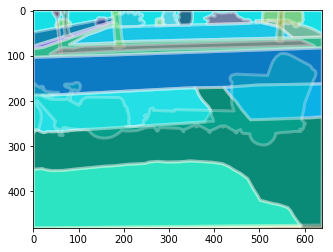

In [6]:
dataDir = 'datasets/coco_amodal/val2014'
for i in range(1322):
    #imgId = random.choice(amodal.dataset['images'])['id']
    imgId = amodal.dataset['images'][i]['id']
    annIds = amodal.getAmodalAnnIds(imgIds=imgId)
    anns = amodal.loadAnns(annIds)
    ann = random.choice(anns)
    img = amodal.loadImgs(imgId)[0]
    
    name = os.path.join(dataDir, img['file_name'])
    I = cv2.imread(name)
    
    
    cmd = 'cp ' + name + ' /root/chenap/pytorch-deeplab-xception/val_result/'
    name_sub = os.path.basename(name)
    os.system(cmd)
    
    #plt.figure()
    plt.imshow(I[:,:,[2,0,1]])
    amodal.showAmodalAnns(ann) 
    plt.savefig('./visualize_gt/%s_layer.png' %name_sub[:-4],dpi=200)

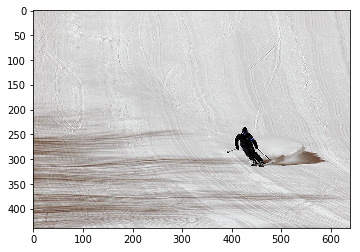

In [6]:
# random select one image
dataDir = 'datasets/coco_amodal/train2014'
imgId = random.choice(amodal.dataset['images'])['id']
annIds = amodal.getAmodalAnnIds(imgIds=imgId)
anns = amodal.loadAnns(annIds)
ann = random.choice(anns)
img = amodal.loadImgs(imgId)[0]
I = cv2.imread(os.path.join(dataDir, img['file_name']))
plt.figure()
plt.imshow(I)

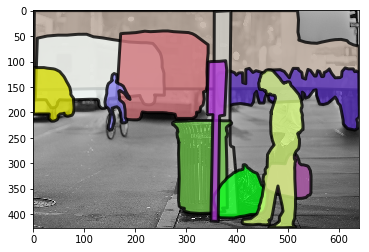

In [12]:
plt.figure()
plt.imshow(I)
amodal.showAmodalAnns(ann) 

In [20]:
train_img = []
ImgIds = amodal.getImgIds()
with open('val_list.txt', 'w') as f:
    for i in range(len(ImgIds)):
        img = amodal.loadImgs(ImgIds[i])[0]
        f.write("%s\n" % img['file_name'])
    f.close()

In [25]:
images_list = []
with open('val_list.txt', 'r') as f:
    images_list.append(f.readlines())

In [4]:
anns = amodal.anns
ids = amodal.getAmodalAnnIds()

In [12]:
names = {}
for i in range(len(ids)):
    regions = anns[ids[i]]['regions']
    for seg in regions:
        names[seg['name']] = 1

In [17]:
images = amodal.dataset['images']
isStuffs = []
for img in images:
    Image_ann = []
    imgId = img['id']
    annIds = amodal.getAmodalAnnIds(imgIds=imgId)
    ann = amodal.loadAnns(annIds)[0]
    
    isStuff = []
    Image_ann = {'id': imgId}
    Image_ann['mask_amodals'] = []
    for depth in range(len(ann['regions'])):
        isStuff.append(ann['regions'][depth]['isStuff'])
    isStuffs.append(isStuff)
isStuffs_val = isStuffs